## Environment Setting

In [1]:
import torch
from PIL import Image, UnidentifiedImageError
from torch.utils.data import Dataset, DataLoader, random_split
import os
import pandas as pd
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import random
import torchvision.transforms.functional as TF
#from sklearn.model_selection import KFold 
import numpy as np
from torch.utils.tensorboard import SummaryWriter



## DataLoader

### Load Image

In [2]:
class MyDataset(Dataset):
    def __init__(self, 
                 root, 
                 if_train = True,
                 data_dir = "train",
                 color_dir = "color",
                 depth_dir = "depth_raw",
                 rgb_name = "rgb.png",
                 depth_name="depth_raw.png",
                 csv_name = "nutrition5k_train.csv",
                 transform = None, 
                 ):
        self.root = root
        self.data = self.root / data_dir
        self.color_dir  = self.data / color_dir
        self.depth_dir = self.data / depth_dir
        self.rgb_name = rgb_name
        self.depth_name = depth_name
        self.if_train = if_train
        


        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.normalize_depth = transforms.Normalize(mean=[0.5], std=[0.5])
        self.color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    

        if self.if_train:
            df = pd.read_csv(self.root / csv_name)
            self.id2cal = {str(r["ID"]) : float(r["Value"]) for _, r in df.iterrows()}

        rgb_paths = sorted((p / rgb_name for p in self.color_dir.glob("dish_*") if (p / rgb_name).exists()))
        if not rgb_paths:
            raise RuntimeError(f"Found 0 images in {self.color_dir}.")
        
        self.samples = []
        if self.if_train:
            for rgb_path in rgb_paths:
                dish_id = rgb_path.parent.name
                if dish_id not in self.id2cal:
                    print(f"Warning: {dish_id} not found in CSV.")
                depth_path = self.depth_dir / dish_id / self.depth_name 
                self.samples.append((rgb_path, depth_path, self.id2cal[dish_id]))
        else:
            for rgb_path in rgb_paths:
                dish_id = rgb_path.parent.name
                depth_path = self.depth_dir / dish_id / self.depth_name 
                self.samples.append((rgb_path, depth_path, None))
                
    def __len__(self):
            return len(self.samples)

    def __getitem__(self, idx):
        try:
            rgb_path, depth_path, cal = self.samples[idx]
            rgb = Image.open(rgb_path).convert("RGB")
            depth = Image.open(depth_path).convert("L")

            # Data enhencement
            if self.if_train:
                # 1. Fixed crop: from left=140, size=480x480
                rgb = TF.crop(rgb, top=0, left=140, height=480, width=480)
                depth = TF.crop(depth, top=0, left=140, height=480, width=480)

                # 2. Random 90-degree rotation
                k = random.randint(0, 3)  # 0: 0°, 1: 90°, 2: 180°, 3: 270°
                if k > 0:
                    rgb = TF.rotate(rgb, angle=90 * k, interpolation=TF.InterpolationMode.BILINEAR)
                    depth = TF.rotate(depth, angle=90 * k, interpolation=TF.InterpolationMode.NEAREST)

            else:
                # Apply same fixed crop for validation/test
                rgb = TF.crop(rgb, top=0, left=140, height=480, width=480)
                depth = TF.crop(depth, top=0, left=140, height=480, width=480)

            
            rgb = self.to_tensor(rgb)
            depth = self.to_tensor(depth)
            rgb = self.normalize(rgb)
            depth = self.normalize_depth(depth)

            if self.if_train:
                cal = torch.tensor(cal, dtype=torch.float32)
                return rgb, depth, cal
            else:
                return rgb, depth

        except (UnidentifiedImageError, FileNotFoundError, Exception) as e:
            print(f"waring: index {idx} sample processing fail, will be taken place by original sample。error: {e}")
            new_idx = random.randint(0, len(self) - 1)
            return self.__getitem__(new_idx)
        

In [3]:
print(Path.cwd())

/mnt/c/Users/lhg45/Desktop/COMP90086/PJ/Nutrition5K


In [4]:
train_set = MyDataset(root=Path.cwd(), if_train=True, transform=False)
test_set = MyDataset(root=Path.cwd(), data_dir="test", if_train=False, transform=False)

dataset_size = len(train_set)
val_ratio = 0.1
val_size = int(dataset_size * val_ratio)
train_size = dataset_size - val_size
train_subset, val_subset = random_split(train_set, [train_size, val_size])

#torch.manual_seed(42) 

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True,
                          num_workers=8, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False,
                        num_workers=8, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=32, shuffle=False,
                          num_workers=8, pin_memory=True)

# Model Definition

In [5]:
# --------- CBAM ---------
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.shared_mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels // ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // ratio, in_channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_out = self.shared_mlp(self.avg_pool(x).view(b, c))
        max_out = self.shared_mlp(self.max_pool(x).view(b, c))
        out = avg_out + max_out
        return self.sigmoid(out).view(b, c, 1, 1)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x_cat))

class CBAM(nn.Module):
    def __init__(self, in_channels, ratio=16, kernel_size=7):
        super().__init__()
        self.channel_att = ChannelAttention(in_channels, ratio)
        self.spatial_att = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_att(x)
        x = x * self.spatial_att(x)
        return x

# --------- Fusion Gate ---------
class FusionGate(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.gate = nn.Sequential(
            nn.Conv2d(channels * 2, channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, rgb, depth):
        g = self.gate(torch.cat([rgb, depth], dim=1))
        return rgb * g + depth * (1 - g)

# --------- Residual Block + CBAM ---------
class PreActResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)

        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)

        self.shortcut = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels,
                                      kernel_size=1, stride=stride, bias=False)

        self.cbam = CBAM(out_channels)

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(self.relu1(self.bn1(x)))
        out = self.conv2(self.relu2(self.bn2(out)))
        out = self.cbam(out)
        return out + identity

# --------- Backbone ---------
class ResidualBranch(nn.Module):
    def __init__(self, in_ch=3):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = PreActResidualBlock(64, 128, stride=2)
        self.layer2 = PreActResidualBlock(128, 256, stride=2)
        self.layer3 = PreActResidualBlock(256, 512, stride=2)

    def forward(self, x):
        x = self.stem(x)
        c2 = self.layer1(x)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        return [c2, c3, c4]

# --------- FPN ---------
class FPN(nn.Module):
    def __init__(self, in_channels=[128,256,512], out_channels=256):
        super().__init__()
        self.lateral_convs = nn.ModuleList([
            nn.Conv2d(c, out_channels, kernel_size=1) for c in in_channels
        ])
        self.output_convs = nn.ModuleList([
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1) for _ in in_channels
        ])

    def forward(self, features):
        c2, c3, c4 = features
        p4 = self.lateral_convs[2](c4)
        p3 = self.lateral_convs[1](c3) + F.interpolate(p4, size=c3.shape[2:], mode="nearest")
        p2 = self.lateral_convs[0](c2) + F.interpolate(p3, size=c2.shape[2:], mode="nearest")

        p2 = self.output_convs[0](p2)
        p3 = self.output_convs[1](p3)
        p4 = self.output_convs[2](p4)
        return [p2, p3, p4]

# --------- Head ---------
class Head(nn.Module):
    def __init__(self, in_features=256*3):
        super().__init__()
        self.fc = nn.Sequential(
            nn.LayerNorm(in_features),
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            nn.Linear(512, 64),
            nn.LayerNorm(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),

            nn.Linear(64, 1)
        )

    def forward(self, feats):
        pooled = [F.adaptive_avg_pool2d(f, 1).flatten(1) for f in feats]
        x = torch.cat(pooled, dim=1)
        return self.fc(x).squeeze(1)

# --------- RGBDNet ---------
class RGBDNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.rgb   = ResidualBranch(3)
        self.depth = ResidualBranch(1)
        self.fpn_rgb   = FPN([128,256,512], 256)
        self.fpn_depth = FPN([128,256,512], 256)
        self.fusion = nn.ModuleList([FusionGate(256) for _ in range(3)])
        self.head  = Head(in_features=256*3)

    def forward(self, rgb, depth):
        f_rgb   = self.rgb(rgb)
        f_depth = self.depth(depth)

        p_rgb   = self.fpn_rgb(f_rgb)
        p_depth = self.fpn_depth(f_depth)

        fused = [self.fusion[i](r, d) for i, (r, d) in enumerate(zip(p_rgb, p_depth))]
        return self.head(fused)


# Training

In [6]:

class DualThresholdEarlyStopping:
    def __init__(self, train_threshold=5000.0, val_threshold=5000.0):
        self.train_threshold = train_threshold
        self.val_threshold = val_threshold
        self.early_stop = False

    def __call__(self, train_loss, val_loss):
        if train_loss < self.train_threshold and val_loss < self.val_threshold:
            self.early_stop = True


if torch.cuda.is_available():
    print(f"detect {torch.cuda.device_count()} GPU available。")
    device = torch.device('cuda')
else:
    print("No GPU detect, running on cpu")
    device = torch.device('cpu')


model = RGBDNet().to(device)

checkpoint_path = "checkpoints/FFN_FusionGate_CBAM_epoch500_10_26.pth"
model.load_state_dict(torch.load(checkpoint_path))

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
)
criterion = nn.MSELoss()
early_stopper = DualThresholdEarlyStopping(train_threshold=4000, val_threshold=4000)


writer = SummaryWriter(log_dir="runs/grad_monitor")


train_losses, val_losses = [], []
train_smapes, val_smapes = [], []

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss, smape_sum, n_batches = 0.0, 0.0, 0
    print("Start epoch: " + str(epoch+1))
    image_count = 0

    for rgb, depth, cal in train_loader:
        rgb, depth, cal = rgb.to(device), depth.to(device), cal.to(device)

        pred = model(rgb, depth)
        loss = criterion(pred, cal)

        optimizer.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=25000)
        optimizer.step()

        running_loss += loss.item() * rgb.size(0)
        smape_batch = torch.mean(
            2 * torch.abs(pred - cal) / (torch.abs(pred) + torch.abs(cal) + 1e-8)
        ).item()
        smape_sum += smape_batch
        n_batches += 1

        image_count += rgb.size(0)
        print(f"Processed {image_count} images", end='\r')

    train_loss = running_loss / len(train_loader.dataset)
    train_smape = smape_sum / n_batches
    train_losses.append(train_loss)
    train_smapes.append(train_smape)

    model.eval()
    val_loss, smape_sum, n_batches = 0.0, 0.0, 0
    with torch.no_grad():
        for rgb, depth, cal in val_loader:
            rgb, depth, cal = rgb.to(device), depth.to(device), cal.to(device)
            pred = model(rgb, depth)
            loss = criterion(pred, cal)
            val_loss += loss.item() * rgb.size(0)
            smape_batch = torch.mean(
                2 * torch.abs(pred - cal) / (torch.abs(pred) + torch.abs(cal) + 1e-8)
            ).item()
            smape_sum += smape_batch
            n_batches += 1

    val_loss /= len(val_loader.dataset)
    val_smape = smape_sum / n_batches
    val_losses.append(val_loss)
    val_smapes.append(val_smape)

    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("SMAPE/train", train_smape, epoch)
    writer.add_scalar("SMAPE/val", val_smape, epoch)
    writer.add_scalar("LR", optimizer.param_groups[0]['lr'], epoch)

    for name, param in model.named_parameters():
        if param.grad is not None:
            writer.add_histogram(f"grad/{name}", param.grad, epoch)

    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2).item()
            total_norm += param_norm ** 2
    total_norm = total_norm ** 0.5
    writer.add_scalar("Grad/total_norm", total_norm, epoch)

    torch.cuda.empty_cache()

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train SMAPE: {train_smape*100:.3f}%, Val SMAPE: {val_smape*100:.3f}%, "
          f"GradNorm: {total_norm:.3f}")

    # Early stopping
    early_stopper(train_loss, val_loss)
    if early_stopper.early_stop:
        print("✅ Early stopping: both train and val loss thresholds met.")
        break

writer.close()


detect 1 GPU available。
Start epoch: 1
Epoch [1/100] | Train Loss: 5356.5216, Val Loss: 1577.1648, Train SMAPE: 34.673%, Val SMAPE: 38.764%, GradNorm: 63773.844
Start epoch: 2
Epoch [2/100] | Train Loss: 5701.3958, Val Loss: 1266.6678, Train SMAPE: 35.128%, Val SMAPE: 37.044%, GradNorm: 88141.847
Start epoch: 3
Epoch [3/100] | Train Loss: 5386.0644, Val Loss: 1383.5108, Train SMAPE: 35.179%, Val SMAPE: 37.266%, GradNorm: 105799.210
Start epoch: 4
Epoch [4/100] | Train Loss: 5214.4675, Val Loss: 1271.3231, Train SMAPE: 34.814%, Val SMAPE: 36.915%, GradNorm: 346579.792
Start epoch: 5
Epoch [5/100] | Train Loss: 5283.7692, Val Loss: 1582.8781, Train SMAPE: 34.811%, Val SMAPE: 38.681%, GradNorm: 49520.000
Start epoch: 6
Epoch [6/100] | Train Loss: 5551.9831, Val Loss: 1578.3627, Train SMAPE: 34.794%, Val SMAPE: 38.108%, GradNorm: 39463.145
Start epoch: 7
Epoch [7/100] | Train Loss: 5510.5811, Val Loss: 1455.0719, Train SMAPE: 34.279%, Val SMAPE: 38.174%, GradNorm: 95881.914
Start epoch: 8


In [7]:
save_path = "checkpoints/FFN_FusionGate_CBAM_epoch600_10_26.pth" 
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")


Model weights saved to checkpoints/FFN_FusionGate_CBAM_epoch600_10_26.pth


## Plot

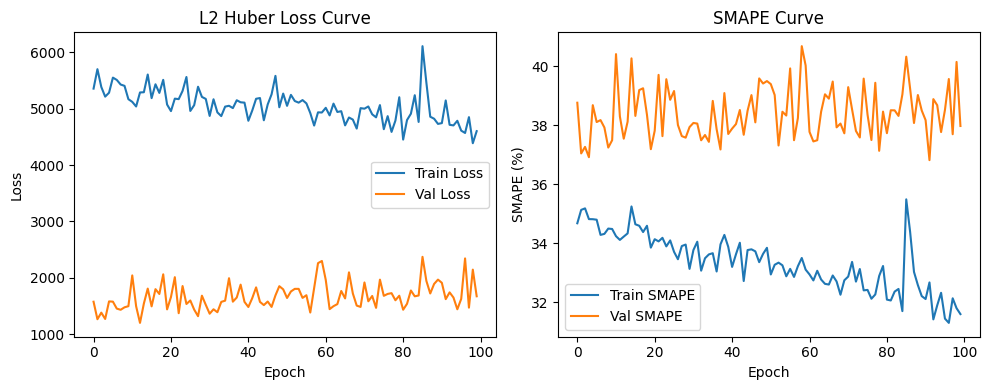

In [8]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('L2 Huber Loss Curve'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot([m*100 for m in train_smapes], label='Train SMAPE')
plt.plot([m*100 for m in val_smapes], label='Val SMAPE')
plt.title('SMAPE Curve'); plt.xlabel('Epoch'); plt.ylabel('SMAPE (%)'); plt.legend()

plt.tight_layout()
plt.show()

# Testing

In [9]:
model.eval()
predictions = []
submission_df = pd.DataFrame({"ID": [], "Value": []})
with torch.no_grad():
    for rgb, depth in test_loader:
        rgb, depth = rgb.to(device), depth.to(device)
        pred = model(rgb, depth)
        predictions.extend(pred.cpu().numpy())

submission_df = pd.DataFrame({
    "ID": [f"dish_{3300+i:04d}" for i in range(1, len(predictions)+1)],
    "Value": [0 if val < 5 else val for val in predictions]
})



In [10]:
output_filepath = "submission.csv"

submission_df.to_csv(output_filepath, index=False)